In [47]:
%run Classes/SPDEs.ipynb
%run Classes/Rule.ipynb
%run Classes/Noise.ipynb
%run Algorithms/Algorithm_1.ipynb
%run Classes/Model.ipynb
%run Classes/Experiment.ipynb

In [5]:
dx, dt = 0.01, 0.001 #space-time increments 
k = 1000 # Number of realizations
a, b, s, t = 0, 1, 0, 1 # space-time boundaries

X, T = Noise().partition(a,b,dx), Noise().partition(s,t,dt) # space grid O_X and time grid O_T

W = Noise().WN_space_time_many(s, t, dt, a, b, dx, k) # Create realizations of space time white noise

In [3]:
ic = lambda x: x*(1-x) # initial condition
mu = lambda x: 3*x-x**3 # drift
sigma1 = lambda x: x # multiplicative diffusive term
sigma2 = lambda x: 1 # additive diffusive term

\begin{align}
(\partial_t - \Delta) u &= 3u - u^3 + u\cdot\xi\,\quad\text{for $(t,x) \in [0,1]\times [0,1]$,}\\
u(t,0) &= u(t,1)\quad\text{(Periodic BC)}\\
u(0,x) &= x(1-x)
\end{align}

In [6]:
# solutions to the multiplicative equation 
Soln_mult = SPDE(BC = 'P', IC = ic, mu = mu, sigma = sigma1).Parabolic(W, T, X)

\begin{align}
(\partial_t - \Delta) u &= 3u - u^3 + \xi\,\quad\text{for $(t,x) \in [0,1]\times [0,1]$,}\\
u(t,0) &= u(t,1) = 0 \quad\text{(Periodic BC)}\\
u(0,x) &= x(1-x)
\end{align}

In [7]:
# solutions to the additive equation 
Soln_add = SPDE(BC = 'P', IC = ic, mu = mu, sigma = sigma2).Parabolic(W, T, X)

\begin{align}
(\partial_t - \Delta) I[\xi] &= \xi\,\quad\text{for $(t,x) \in [0,1]\times [0,1]$,}\\
I[\xi](t,0) &= I[\xi](t,1)\\
I[\xi](0,x) &= 0
\end{align}

In [8]:
# solutions to the linearized equation

I_xi = SPDE(BC = 'P', IC = lambda x: 0, mu = lambda x: 0, sigma = sigma2).Parabolic(W, T, X)

# Will be used as an input to the model in order to speed up the model computation. All I_xi are solved in paralel

In [9]:
# Multiplicative equation model and features construction

R = Rule(kernel_deg = 2, noise_deg = -1.5, free_num = 3) # create rule with additive width 3
R.add_component(1, {'xi':1}) # add multiplicative width = 1

I = SPDE(BC = 'P', T = T, X = X).Integrate_Parabolic_trees # initialize integration map I

M = Model(integration = I, rule = R, height = 4, deg = 5) # initialize model

# Set time-space points at which functions of the model will be evaluated and stored in memory
points = {(-1,50), (50,50), (200,50), (-1,95), (500,50)}

# create model
Features_for_points = M.create_model_points(W, lollipops = I_xi, diff = True, dt = dt, points = points)

'''
No trees of the form I_c[u_0] are added so the model without initial conditions is created
In order to add I_c[u_0] to the model need to solve 
W_0 = np.zeros((1, len(T), len(X)))
I_c = SPDE(BC = 'D', T = T, X = X, IC = ic, mu = lambda x: 0, sigma = lambda x: 0).Parabolic(W_0, T, X)

Then call
Features_for_points = M.create_model_points(W, lollipops = I_xi, diff = True, dt = dt, extra_planted = I_c, extra_deg = 2, key = "I_c[u_0]",  points = points)
''';

100%|██████████| 1000/1000 [06:05<00:00,  2.74it/s] 


In [10]:
# Create subsets of symbols for models of lower heights

W_toy = np.zeros(shape = (1, 2, 2)) # small toy noise
I_toy = SPDE(BC = 'P', T = np.array([0,1]), X = np.array([0,1])).Integrate_Parabolic_trees

M_toy = {i : Model(I_toy, R, i, 5) for i in range(1,5)} # initialize toy models of heights 1,2,3,4

for a in M_toy:
    
    M_toy[a].create_model_list(W_toy, lollipops = W_toy, diff = True, dt = 1)
    
trees = {a: list(M_toy[a].models[0].keys()) for a in M_toy} # extract feature set for every height

trees_add = [a for a in trees[4] if 'xi(' not in a] # feature set for model without forcing

100%|██████████| 1/1 [00:00<00:00, 62.13it/s]


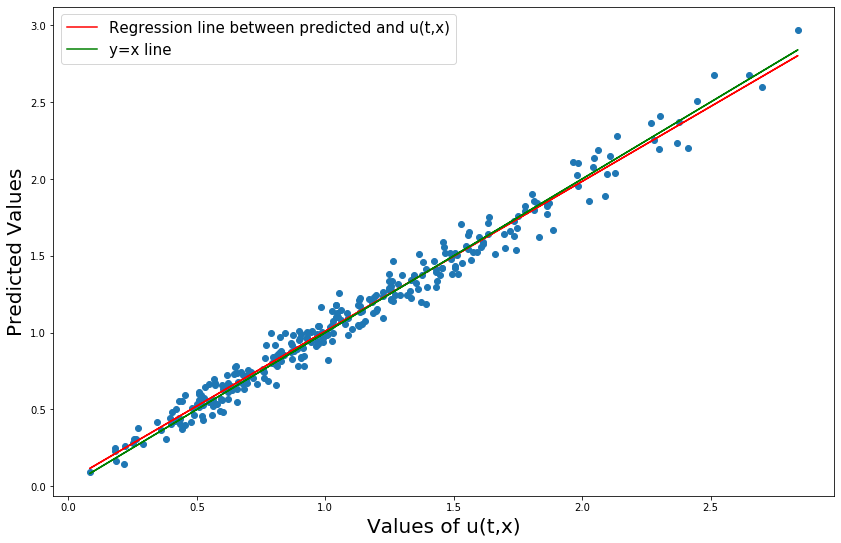

Error: 0.0656187284514976. Error std: 0.04941579595971895. Tangent: 0.9743194430502765. R^2: 0.9774639576562045.


In [31]:
#  Multiplicative equation experiment

t1, x1 = -1, 50 # Point where prediction will be made
E = Experiment(t1, x1, t1, x1)
E.F = Features_for_points[(t1,x1)]
E.L = Soln_mult[:,t1,x1]
E.one_experiment(split = True)
E.show_regression_experiment(metric = err2)

In [27]:
#  Multiplicative equation repeated experiments

repeat_num = 1000
er1, std1, t1, r1 = E.many_regression_experiments(repeat_num, columns = trees[1])
er2, std2, t2, r2 = E.many_regression_experiments(repeat_num, columns = trees[2])
er3, std3, t3, r3 = E.many_regression_experiments(repeat_num, columns = trees[3])
er4, std4, t4, r4 = E.many_regression_experiments(repeat_num, columns = trees[4])
er1, std1, t1, r1 = round(100*er1, 2), round(100*std1, 2), round(t1, 3), round(r1, 3)
er2, std2, t2, r2 = round(100*er2, 2), round(100*std2, 2), round(t2, 3), round(r2, 3)
er3, std3, t3, r3 = round(100*er3, 2), round(100*std3, 2), round(t3, 3), round(r3, 3)
er4, std4, t4, r4 = round(100*er4, 2), round(100*std4, 2), round(t4, 3), round(r4, 3)

100%|██████████| 1000/1000 [00:15<00:00, 66.42it/s]


In [30]:
print('Repeating Experiment {} times.'.format(repeat_num))
print("Height = {}, Avg Error: {}%. Avg Error Std {}%. Avg Slope {}. Avg R^2 {}.".format(1, er1, std1, t1, r1))
print("Height = {}, Avg Error: {}%. Avg Error Std {}%. Avg Slope {}. Avg R^2 {}.".format(2, er2, std2, t2, r2))
print("Height = {}, Avg Error: {}%. Avg Error Std {}%. Avg Slope {}. Avg R^2 {}.".format(3, er3, std3, t3, r3))
print("Height = {}, Avg Error: {}%. Avg Error Std {}%. Avg Slope {}. Avg R^2 {}.".format(4, er4, std4, t4, r4))

Repeating Experiment 1000 times.
Height = 1, Avg Error: 18.87%. Avg Error Std 17.94%. Avg Slope 0.721. Avg R^2 0.716.
Height = 2, Avg Error: 11.36%. Avg Error Std 10.91%. Avg Slope 0.899. Avg R^2 0.896.
Height = 3, Avg Error: 6.56%. Avg Error Std 6.05%. Avg Slope 0.969. Avg R^2 0.966.
Height = 4, Avg Error: 5.88%. Avg Error Std 5.05%. Avg Slope 0.978. Avg R^2 0.975.


In [112]:
# Addtitive equation model and features construction

R_add = Rule(kernel_deg = 2, noise_deg = -1.5, free_num = 3) # create rule with additive width 3. No multiplicative component

M_add = Model(integration = I, rule = R_add, height = 5, deg = 7.5) # initialize model for additive equation

# Set time-space points at which functions of the model will be evaluated and stored in memory
points = {(-1,50), (50,50), (200,50), (-1,95), (500,50)}

Features_for_points_add = M_add.create_model_points(W, lollipops = I_xi, diff = True, dt = dt, points = points)

100%|██████████| 1000/1000 [08:16<00:00,  2.01it/s]


100%|██████████| 1000/1000 [00:00<00:00, 6443.47it/s]

Creating labels dataset.


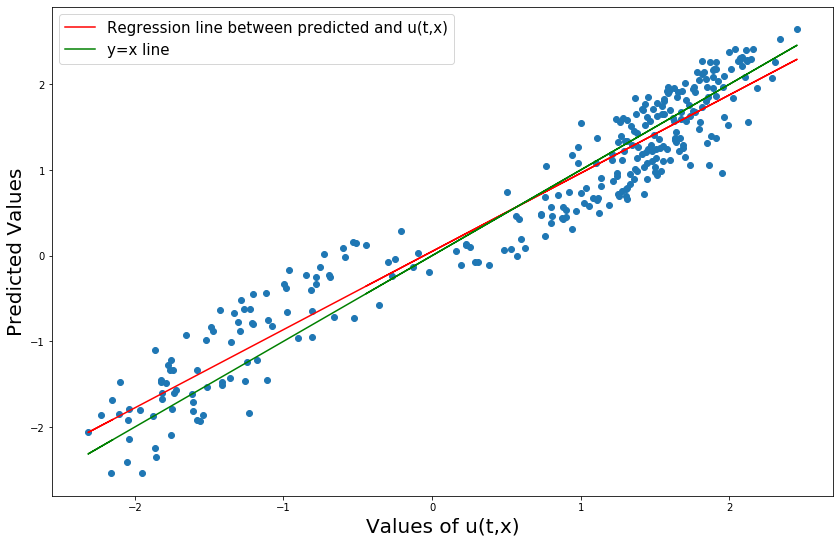

Error: 0.25016028093029724 . Tangent: 0.9130035123667369


In [124]:
# Additive equation experiment

t2, x2 = -1, 50 # Point where prediction will be made
E2 = Experiment(t2, x2, t2, x2)
E2.F = Features_for_points_add[(t2,x2)]
E2.L = Soln_add[:,t2,x2]
E2.one_experiment(split = True)
E2.show_regression_experiment(metric = err2)

100%|██████████| 1000/1000 [00:00<00:00, 7516.43it/s]

Creating labels dataset.


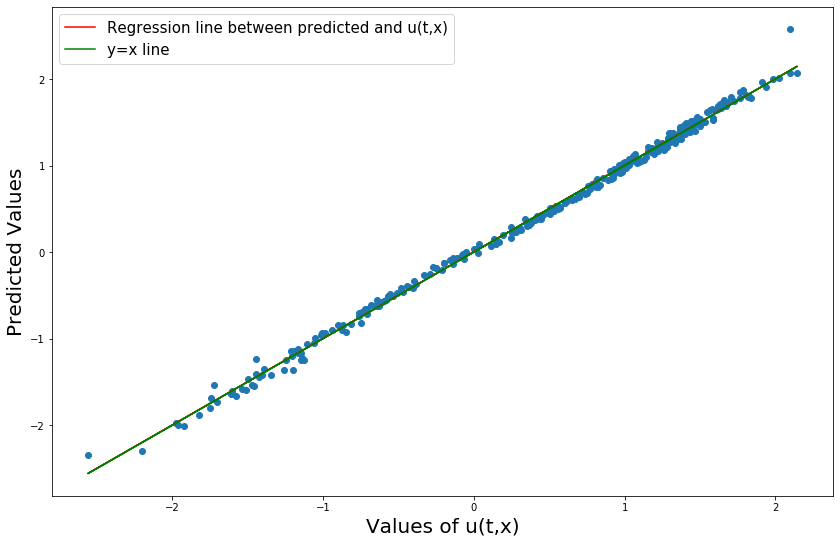

Error: 0.05261714344480932 . Tangent: 0.9998856688838418


In [118]:
t3, x3 = 500, 50 # Point where prediction will be made
E3 = Experiment(t3, x3, t3, x3)
E3.F = Features_for_points_add[(t3,x3)]
E3.L = Soln_add[:,t3,x3]
E3.one_experiment(split = True)
E3.show_regression_experiment(metric = err2)

In [119]:
er1_add, std1_add, t1_add, r1_add = E2.many_regression_experiments(repeat_num, columns = trees[1])
er2_add, std2_add, t2_add, r2_add = E3.many_regression_experiments(repeat_num, columns = trees[2])
er1_add, std1_add, t1_add, r1_add = round(100*er1_add, 2), round(100*std1_add, 2), round(t1_add, 3), round(r1_add, 3)
er2_add, std2_add, t2_add, r2_add = round(100*er2_add, 2), round(100*std2_add, 2), round(t2_add, 3), round(r2_add, 3)

print("Average error for the additive equation :" er1_add)

100%|██████████| 1000/1000 [00:14<00:00, 67.71it/s]

Average error for the additive equation: 0.0630881791929921


In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
# Create a one vector from the noise

n, m = 1, 1 # resolution. We take every n-th time point and every m-th space point

W_flat = np.array([noise[1::n, :-1:m].flatten() for noise in W])
size = W_flat[0].shape[0]
W_flat = pd.DataFrame(W_flat, columns=np.arange(size), index=np.arange(len(W_flat)))

print("Number of points of noise, used for learning and predicting: ", size)

In [ ]:
E_forest = Experiment(t1, x1, t1, x1, algorithm=RandomForestRegressor())
E_forest.F = W_flat
E_forest.L = Soln_mult[:, t1, x1]
E_forest.one_experiment(split = True)
E_forest.show_regression_experiment(metric = err2)

In [ ]:
E_svr = Experiment(t1, x1, t1, x1, algorithm=SVR())
E_svr.F = W_flat
E_svr.L = Soln_mult[:, t1, x1]
E_svr.one_experiment(split = True)
E_svr.show_regression_experiment(metric = err2)

In [ ]:
E_neightbours = Experiment(t1, x1, t1, x1, algorithm=KNeighborsRegressor())
E_neightbours.F = W_flat
E_neightbours.L = Soln_mult[:, t1, x1]
E_neightbours.one_experiment(split = True)
E_neightbours.show_regression_experiment(metric = err2)